# Imports

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

import numpy as np
import cv2
import os
import glob # Para listar archivos
from tqdm import tqdm
import matplotlib.pyplot as plt

# Librerías CRÍTICAS para la Segmentación (Albumentations)
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Data Loaders

In [2]:
# --- AJUSTAR ESTAS RUTAS Y CONSTANTES ---
# Asegúrate de que estas carpetas existan en tu entorno
TRAIN_IMAGES_DIR = 'train/images'
TRAIN_MASKS_DIR = 'train/masks'
BATCH_SIZE = 4

# Valores de Normalización Z-Score (Paso 2 del EDA)
MEAN = [0.515, 0.484, 0.460] 
STD = [0.314, 0.303, 0.303]
# ----------------------------------------

# REDUCCIÓN CRÍTICA: Redimensionamos a 256x256 (o 256x256 si 512 es mucho)
IMG_HEIGHT = 256
IMG_WIDTH = 256

# Obtener la lista de todos los archivos (asumiendo que los nombres coinciden en imagen y máscara)
# Esto es esencial para el constructor del Dataset
all_files = os.listdir(TRAIN_IMAGES_DIR)
all_files = [f for f in all_files if f.endswith('.png') or f.endswith('.jpg')]

In [3]:
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2 

def get_transforms(phase, mean, std):
    
    if phase == 'train':
        return A.Compose([
            # 💡 MODIFICACIÓN CLAVE: Redimensionar para gestionar la memoria
            A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH, always_apply=True), 

            # Augmentation Geométrica
            A.HorizontalFlip(p=0.5), 
            A.ShiftScaleRotate(shift_limit=0.15, scale_limit=0.1, rotate_limit=15, p=0.7, border_mode=cv2.BORDER_CONSTANT),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.4, border_mode=cv2.BORDER_CONSTANT), 
            
            # Augmentation de Textura y Color
            A.GaussNoise(var_limit=(10.0, 50.0), p=0.5), 
            A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.5, hue=0.05, p=0.8), 

            # Normalización y Conversión a Tensor
            A.Normalize(mean=mean, std=std, max_pixel_value=255.0),
            ToTensorV2(), 
        ])
    
    # Validation/Test: Solo redimensionamiento y normalización
    else: 
        return A.Compose([
            # 💡 MODIFICACIÓN CLAVE: Redimensionar en validación también
            A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH, always_apply=True),
            A.Normalize(mean=mean, std=std, max_pixel_value=255.0),
            ToTensorV2(),
        ])

In [4]:
class HumanSegmentationDataset(Dataset):
    """Clase base que carga datos como NumPy Arrays."""
    def __init__(self, image_dir, mask_dir):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        # Asegura la lista de archivos base
        self.image_files = os.listdir(image_dir)
        self.image_files = [f for f in self.image_files if f.endswith(('.png', '.jpg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        filename = self.image_files[idx]
        img_path = os.path.join(self.image_dir, filename)
        mask_path = os.path.join(self.mask_dir, filename)
        
        # Cargar imagen (RGB)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # RGB (H, W, 3)
        
        # Cargar máscara (Grayscale)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # (H, W)
        mask = (mask > 0).astype(np.float32) # Binarizar 0/1 (float32)

        # CRÍTICO: Devolver NumPy arrays SIN aplicar transformaciones
        return image, mask


class SubsetWrapper(Dataset): 
    """Aplica el transform específico (train o val) al Subset."""
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        # La llamada a self.subset[idx] usa el __getitem__ de HumanSegmentationDataset y devuelve NumPy arrays
        image_np, mask_np = self.subset[idx]
        
        # Aplicamos la transformación Sincronizada (Albumentations)
        if self.transform:
            augmented = self.transform(image=image_np, mask=mask_np)
            image_tensor = augmented['image'] # (3, H, W)
            mask_tensor = augmented['mask']   # (H, W)
            
            # Asegurar que la máscara tenga la dimensión de canal (1, H, W)
            if mask_tensor.ndim == 2:
                mask_tensor = mask_tensor.unsqueeze(0) 
            
            return image_tensor, mask_tensor
        
        # Si no hay transform (caso de emergencia, no debería ocurrir aquí)
        # Esto solo lo devolvería si transform es None
        return image_np, mask_np

In [5]:
def get_dataloaders(train_ratio=0.8, batch_size=BATCH_SIZE, num_workers=0):
    
    # 1. Crear el Dataset Base (sin transform)
    full_dataset = HumanSegmentationDataset(
        image_dir=TRAIN_IMAGES_DIR, 
        mask_dir=TRAIN_MASKS_DIR
    )

    # 2. Dividir el Dataset
    total_size = len(full_dataset)
    train_size = int(train_ratio * total_size)
    val_size = total_size - train_size

    train_subset, val_subset = random_split(full_dataset, [train_size, val_size])

    # 3. Obtener los transforms específicos
    train_transforms = get_transforms('train', MEAN, STD)
    val_transforms = get_transforms('val', MEAN, STD)

    # 4. Envolver los Subsets para aplicar la Augmentation correcta
    train_dataset_final = SubsetWrapper(train_subset, train_transforms)
    val_dataset_final = SubsetWrapper(val_subset, val_transforms)

    # 5. Crear DataLoaders
    train_loader = DataLoader(
        train_dataset_final, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=num_workers, 
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset_final, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=num_workers, 
        pin_memory=True
    )
    
    print(f"✅ DataLoaders listos. Train: {len(train_dataset_final)} | Val: {len(val_dataset_final)}")
    return train_loader, val_loader

# --- EJECUTAR PARA OBTENER LOS LOADERS ---
train_loader, val_loader = get_dataloaders()

✅ DataLoaders listos. Train: 1706 | Val: 427


C:\Users\kidni\AppData\Local\Temp\ipykernel_25848\3923470606.py:10: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH, always_apply=True),
c:\Users\kidni\Desktop\u-net-segmentation\.venv\lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\kidni\AppData\Local\Temp\ipykernel_25848\3923470606.py:15: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.4, border_mode=cv2.BORDER_CONSTANT),
C:\Users\kidni\AppData\Local\Temp\ipykernel_25848\3923470606.py:18: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
C:\Users\kidni\AppData\Local\Temp\ipykernel_25848\3923470606.py:30: UserWarning: Argument(s) 'a

In [6]:
def visualize_batch(data_loader, title="Batch de Imágenes", num_samples=4, mean=MEAN, std=STD, figsize=(6, 3)):
    """Extrae un batch y visualiza las imágenes y sus máscaras."""
    
    # 1. Extraer un batch
    images, masks = next(iter(data_loader))
    
    # Calcular tamaño final según num_samples y el factor base figsize
    fig_width, fig_height_base = figsize
    fig, axes = plt.subplots(num_samples, 2, figsize=(fig_width, fig_height_base * num_samples))
    fig.suptitle(title, fontsize=12)

    # 2. Desnormalización y Ploteo
    for i in range(min(num_samples, len(images))):
        img_tensor = images[i].cpu()
        mask_tensor = masks[i].cpu().squeeze(0) # Quitar la dimensión de canal (1, H, W) -> (H, W)

        # Desnormalizar la imagen: img = (img * std) + mean
        # Necesitamos iterar sobre los canales (C=0) para desnormalizar correctamente
        for t, m, s in zip(img_tensor, mean, std):
            t.mul_(s).add_(m)
        
        # PyTorch es C, H, W. Matplotlib espera H, W, C.
        img_np = img_tensor.permute(1, 2, 0).numpy()
        mask_np = mask_tensor.numpy()
        
        # Ploteo de Imagen
        axes[i, 0].imshow(img_np.clip(0, 1)) # clip(0, 1) para manejar los valores fuera del rango por la desnormalización
        axes[i, 0].set_title(f"Muestra {i}: Imagen", fontsize=9)
        axes[i, 0].axis('off')
        
        # Ploteo de Máscara
        axes[i, 1].imshow(mask_np, cmap='gray') # Usar escala de grises para la máscara binaria
        axes[i, 1].set_title(f"Muestra {i}: Máscara", fontsize=9)
        axes[i, 1].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


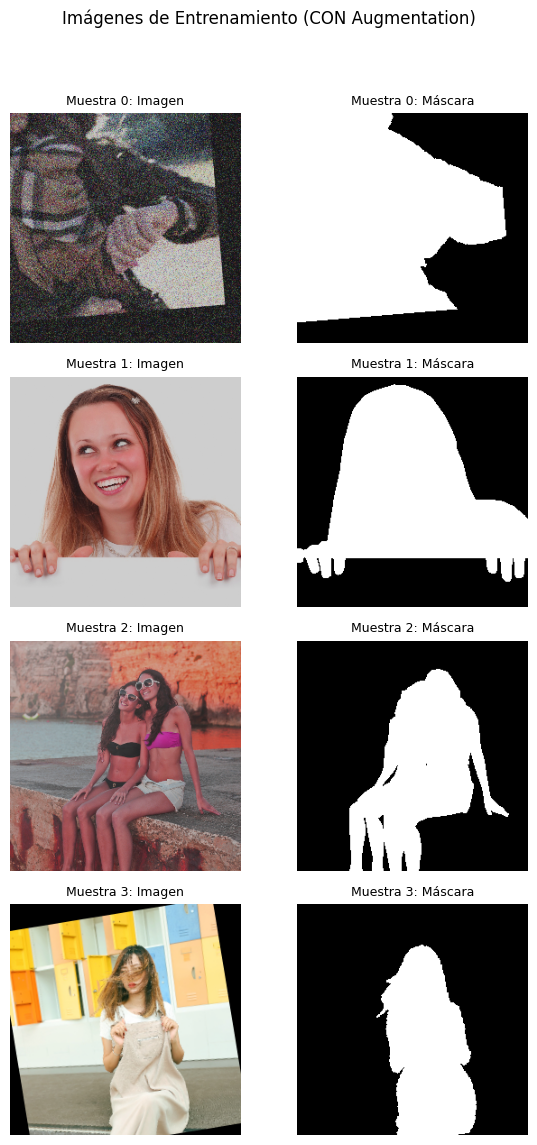

In [7]:
# Asegúrate de que train_loader esté disponible
visualize_batch(train_loader, "Imágenes de Entrenamiento (CON Augmentation)", num_samples=4)

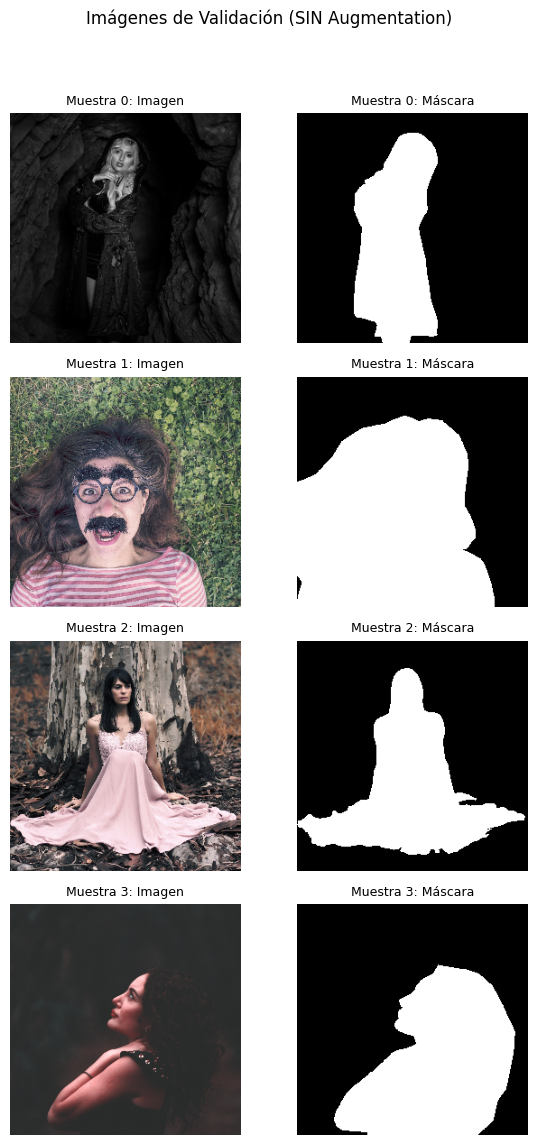

In [8]:
visualize_batch(val_loader, "Imágenes de Validación (SIN Augmentation)", num_samples=4)

# U-Net Model

In [9]:
# --- Bloque Básico de la U-Net ---
class DoubleConv(nn.Module):
    """(Convolución => BatchNorm => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            # Primera convolución
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels), 
            nn.ReLU(inplace=True),

            # Segunda convolución
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels), 
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

# --- Downsampling (Encoder) ---
class Down(nn.Module):
    """Downscaling con MaxPool seguido de DoubleConv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.maxpool_conv(x)

# --- Upsampling (Decoder) ---
class Up(nn.Module):
    """Upscaling y luego DoubleConv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        # El DoubleConv recibe la suma de canales (Up + Skip Connection)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Concatenamos la salida del Up con la Skip Connection del Encoder (x2)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

# --- U-Net Completa ---
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, initial_filters=64):
        super(UNet, self).__init__()
        self.inc = DoubleConv(n_channels, initial_filters)
        self.down1 = Down(initial_filters, initial_filters * 2) 
        self.down2 = Down(initial_filters * 2, initial_filters * 4) 
        self.down3 = Down(initial_filters * 4, initial_filters * 8) 
        self.down4 = Down(initial_filters * 8, initial_filters * 16) # Bottleneck
        
        self.up1 = Up(initial_filters * 16, initial_filters * 8) 
        self.up2 = Up(initial_filters * 8, initial_filters * 4) 
        self.up3 = Up(initial_filters * 4, initial_filters * 2) 
        self.up4 = Up(initial_filters * 2, initial_filters) 
        
        # Capa de salida (Mapea a n_classes = 1)
        self.outc = nn.Conv2d(initial_filters, n_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.inc(x); x2 = self.down1(x1); x3 = self.down2(x2); x4 = self.down3(x3); x5 = self.down4(x4)
        # Decoder
        x = self.up1(x5, x4); x = self.up2(x, x3); x = self.up3(x, x2); x = self.up4(x, x1)
        # Output
        logits = self.outc(x)
        return logits

# Pérdida y Métrica

In [10]:
# --- Función de Pérdida (Justificada por EDA Paso 3) ---
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        # inputs: logits de la U-Net
        inputs = torch.sigmoid(inputs) # Convertir logits a probabilidades (0-1)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_coefficient = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        
        return 1 - dice_coefficient

# --- Métrica de Evaluación (Dice Coefficient) ---
def dice_coefficient(pred_logits, targets, smooth=1e-6):
    probs = torch.sigmoid(pred_logits)
    preds = (probs > 0.5).float() # Binarización (predicciones duras)

    preds = preds.view(-1)
    targets = targets.view(-1)

    intersection = (preds * targets).sum()
    dice = (2. * intersection + smooth) / (preds.sum() + targets.sum() + smooth)
    
    return dice

# Training Loop

In [11]:
# --- Función de Entrenamiento ---
def train_fn(model, data_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_dice = 0.0
    
    for images, masks in tqdm(data_loader, desc="Training"):
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images) 
        loss = criterion(outputs, masks)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        dice_score = dice_coefficient(outputs, masks)

        running_loss += loss.item() * images.size(0)
        running_dice += dice_score.item() * images.size(0)
        
    return running_loss / len(data_loader.dataset), running_dice / len(data_loader.dataset)

# --- Función de Validación ---
@torch.no_grad()
def validate_fn(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_dice = 0.0
    
    for images, masks in tqdm(data_loader, desc="Validation"):
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)
        dice_score = dice_coefficient(outputs, masks)

        running_loss += loss.item() * images.size(0)
        running_dice += dice_score.item() * images.size(0)
        
    return running_loss / len(data_loader.dataset), running_dice / len(data_loader.dataset)

# Primer Setup

In [12]:
import torch.optim as optim
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_EPOCHS = 50 
LEARNING_RATE = 1e-4 

# Instanciar el modelo (n_channels=3, n_classes=1)
model = UNet(n_channels=3, n_classes=1).to(DEVICE)
criterion = DiceLoss() 
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Scheduler: CRÍTICO para regularización (Criterio 3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5
)

# Suponiendo que train_loader y val_loader ya han sido inicializados
# train_loader, val_loader = get_dataloaders() 

best_dice_val = 0.0
history = {'train_loss': [], 'val_loss': [], 'train_dice': [], 'val_dice': []}

print(f"Iniciando entrenamiento en {DEVICE} por {NUM_EPOCHS} épocas...")

# --- BUCLE DE ENTRENAMIENTO ---
for epoch in range(1, NUM_EPOCHS + 1):
    
    # Entrenar
    train_loss, train_dice = train_fn(model, train_loader, optimizer, criterion, DEVICE)
    # Validar
    val_loss, val_dice = validate_fn(model, val_loader, criterion, DEVICE)
    
    # Registrar
    history['train_loss'].append(train_loss); history['val_loss'].append(val_loss)
    history['train_dice'].append(train_dice); history['val_dice'].append(val_dice)
    
    print(f"\nÉpoca {epoch}/{NUM_EPOCHS} | Train Loss: {train_loss:.4f} | Val Dice: {val_dice:.4f}")

    # Scheduler y Checkpoint
    scheduler.step(val_dice)
    
    if val_dice > best_dice_val:
        best_dice_val = val_dice
        checkpoint = {'state_dict': model.state_dict(), 'best_dice': best_dice_val}
        torch.save(checkpoint, "unet_best_checkpoint.pth.tar")
        print(f"➡️ Modelo Guardado. Nuevo mejor Dice: {best_dice_val:.4f}")

Iniciando entrenamiento en cuda por 50 épocas...


Validation: 100%|██████████| 107/107 [00:21<00:00,  5.05it/s]



Época 1/50 | Train Loss: 0.4059 | Val Dice: 0.6984
➡️ Modelo Guardado. Nuevo mejor Dice: 0.6984


Validation: 100%|██████████| 107/107 [00:11<00:00,  9.37it/s]



Época 2/50 | Train Loss: 0.3329 | Val Dice: 0.7255
➡️ Modelo Guardado. Nuevo mejor Dice: 0.7255


Validation: 100%|██████████| 107/107 [00:11<00:00,  9.24it/s]



Época 3/50 | Train Loss: 0.3002 | Val Dice: 0.7463
➡️ Modelo Guardado. Nuevo mejor Dice: 0.7463


Validation: 100%|██████████| 107/107 [00:11<00:00,  9.25it/s]



Época 4/50 | Train Loss: 0.2720 | Val Dice: 0.7678
➡️ Modelo Guardado. Nuevo mejor Dice: 0.7678


Validation: 100%|██████████| 107/107 [00:11<00:00,  9.38it/s]



Época 5/50 | Train Loss: 0.2611 | Val Dice: 0.7690
➡️ Modelo Guardado. Nuevo mejor Dice: 0.7690


Validation: 100%|██████████| 107/107 [00:11<00:00,  9.37it/s]



Época 6/50 | Train Loss: 0.2472 | Val Dice: 0.7770
➡️ Modelo Guardado. Nuevo mejor Dice: 0.7770


Validation: 100%|██████████| 107/107 [00:11<00:00,  9.42it/s]



Época 7/50 | Train Loss: 0.2417 | Val Dice: 0.7713


Validation: 100%|██████████| 107/107 [00:11<00:00,  9.41it/s]



Época 8/50 | Train Loss: 0.2329 | Val Dice: 0.7895
➡️ Modelo Guardado. Nuevo mejor Dice: 0.7895


Validation: 100%|██████████| 107/107 [00:11<00:00,  9.28it/s]



Época 9/50 | Train Loss: 0.2256 | Val Dice: 0.8020
➡️ Modelo Guardado. Nuevo mejor Dice: 0.8020


Validation: 100%|██████████| 107/107 [00:12<00:00,  8.89it/s]



Época 10/50 | Train Loss: 0.2226 | Val Dice: 0.8009


Validation: 100%|██████████| 107/107 [00:12<00:00,  8.49it/s]



Época 11/50 | Train Loss: 0.2170 | Val Dice: 0.8191
➡️ Modelo Guardado. Nuevo mejor Dice: 0.8191


Validation: 100%|██████████| 107/107 [00:12<00:00,  8.34it/s]



Época 12/50 | Train Loss: 0.2113 | Val Dice: 0.8246
➡️ Modelo Guardado. Nuevo mejor Dice: 0.8246


Validation: 100%|██████████| 107/107 [00:12<00:00,  8.27it/s]



Época 13/50 | Train Loss: 0.2072 | Val Dice: 0.8309
➡️ Modelo Guardado. Nuevo mejor Dice: 0.8309


Validation: 100%|██████████| 107/107 [00:12<00:00,  8.27it/s]



Época 14/50 | Train Loss: 0.2033 | Val Dice: 0.8336
➡️ Modelo Guardado. Nuevo mejor Dice: 0.8336


Validation: 100%|██████████| 107/107 [00:12<00:00,  8.44it/s]



Época 15/50 | Train Loss: 0.1977 | Val Dice: 0.8357
➡️ Modelo Guardado. Nuevo mejor Dice: 0.8357


Validation: 100%|██████████| 107/107 [00:12<00:00,  8.45it/s]



Época 16/50 | Train Loss: 0.1957 | Val Dice: 0.8329


Validation: 100%|██████████| 107/107 [00:12<00:00,  8.46it/s]



Época 17/50 | Train Loss: 0.1899 | Val Dice: 0.8322


Validation: 100%|██████████| 107/107 [00:12<00:00,  8.42it/s]



Época 18/50 | Train Loss: 0.1920 | Val Dice: 0.8393
➡️ Modelo Guardado. Nuevo mejor Dice: 0.8393


Validation: 100%|██████████| 107/107 [00:12<00:00,  8.25it/s]



Época 19/50 | Train Loss: 0.1862 | Val Dice: 0.8411
➡️ Modelo Guardado. Nuevo mejor Dice: 0.8411


Validation: 100%|██████████| 107/107 [00:11<00:00,  9.38it/s]



Época 20/50 | Train Loss: 0.1897 | Val Dice: 0.8431
➡️ Modelo Guardado. Nuevo mejor Dice: 0.8431


Validation: 100%|██████████| 107/107 [00:12<00:00,  8.28it/s]



Época 21/50 | Train Loss: 0.1816 | Val Dice: 0.8400


Validation: 100%|██████████| 107/107 [00:12<00:00,  8.31it/s]



Época 22/50 | Train Loss: 0.1793 | Val Dice: 0.8455
➡️ Modelo Guardado. Nuevo mejor Dice: 0.8455


Validation: 100%|██████████| 107/107 [00:11<00:00,  9.43it/s]



Época 23/50 | Train Loss: 0.1760 | Val Dice: 0.8427


Validation: 100%|██████████| 107/107 [00:12<00:00,  8.25it/s]



Época 24/50 | Train Loss: 0.1728 | Val Dice: 0.8460
➡️ Modelo Guardado. Nuevo mejor Dice: 0.8460


Validation: 100%|██████████| 107/107 [00:12<00:00,  8.37it/s]



Época 25/50 | Train Loss: 0.1740 | Val Dice: 0.8449


Validation: 100%|██████████| 107/107 [00:12<00:00,  8.42it/s]



Época 26/50 | Train Loss: 0.1680 | Val Dice: 0.8493
➡️ Modelo Guardado. Nuevo mejor Dice: 0.8493


Validation: 100%|██████████| 107/107 [00:12<00:00,  8.36it/s]



Época 27/50 | Train Loss: 0.1698 | Val Dice: 0.8549
➡️ Modelo Guardado. Nuevo mejor Dice: 0.8549


Validation: 100%|██████████| 107/107 [00:13<00:00,  7.98it/s]



Época 28/50 | Train Loss: 0.1670 | Val Dice: 0.8551
➡️ Modelo Guardado. Nuevo mejor Dice: 0.8551


Validation: 100%|██████████| 107/107 [00:13<00:00,  7.65it/s]



Época 29/50 | Train Loss: 0.1653 | Val Dice: 0.8549


Validation: 100%|██████████| 107/107 [00:11<00:00,  9.43it/s]



Época 30/50 | Train Loss: 0.1627 | Val Dice: 0.8594
➡️ Modelo Guardado. Nuevo mejor Dice: 0.8594


Validation: 100%|██████████| 107/107 [00:11<00:00,  9.16it/s]



Época 31/50 | Train Loss: 0.1607 | Val Dice: 0.8520


Validation: 100%|██████████| 107/107 [00:12<00:00,  8.44it/s]



Época 32/50 | Train Loss: 0.1544 | Val Dice: 0.8664
➡️ Modelo Guardado. Nuevo mejor Dice: 0.8664


Validation: 100%|██████████| 107/107 [00:12<00:00,  8.51it/s]



Época 33/50 | Train Loss: 0.1585 | Val Dice: 0.8675
➡️ Modelo Guardado. Nuevo mejor Dice: 0.8675


Validation: 100%|██████████| 107/107 [00:12<00:00,  8.50it/s]



Época 34/50 | Train Loss: 0.1535 | Val Dice: 0.8556


Validation: 100%|██████████| 107/107 [00:11<00:00,  9.37it/s]



Época 35/50 | Train Loss: 0.1604 | Val Dice: 0.8659


Validation: 100%|██████████| 107/107 [00:11<00:00,  9.45it/s]



Época 36/50 | Train Loss: 0.1521 | Val Dice: 0.8591


Validation: 100%|██████████| 107/107 [00:11<00:00,  9.24it/s]



Época 37/50 | Train Loss: 0.1564 | Val Dice: 0.8648


Validation: 100%|██████████| 107/107 [00:11<00:00,  9.31it/s]



Época 38/50 | Train Loss: 0.1513 | Val Dice: 0.8732
➡️ Modelo Guardado. Nuevo mejor Dice: 0.8732


Validation: 100%|██████████| 107/107 [00:11<00:00,  9.30it/s]



Época 39/50 | Train Loss: 0.1485 | Val Dice: 0.8586


Validation: 100%|██████████| 107/107 [00:11<00:00,  9.29it/s]



Época 40/50 | Train Loss: 0.1513 | Val Dice: 0.8670


Validation: 100%|██████████| 107/107 [00:11<00:00,  9.27it/s]



Época 41/50 | Train Loss: 0.1463 | Val Dice: 0.8771
➡️ Modelo Guardado. Nuevo mejor Dice: 0.8771


Validation: 100%|██████████| 107/107 [00:11<00:00,  9.26it/s]



Época 42/50 | Train Loss: 0.1475 | Val Dice: 0.8735


Validation: 100%|██████████| 107/107 [00:11<00:00,  9.30it/s]



Época 43/50 | Train Loss: 0.1480 | Val Dice: 0.8663


Validation: 100%|██████████| 107/107 [00:11<00:00,  9.28it/s]



Época 44/50 | Train Loss: 0.1441 | Val Dice: 0.8654


Validation: 100%|██████████| 107/107 [00:11<00:00,  9.29it/s]



Época 45/50 | Train Loss: 0.1420 | Val Dice: 0.8728


Validation: 100%|██████████| 107/107 [00:11<00:00,  9.27it/s]



Época 46/50 | Train Loss: 0.1408 | Val Dice: 0.8727


Validation: 100%|██████████| 107/107 [00:11<00:00,  9.28it/s]



Época 47/50 | Train Loss: 0.1420 | Val Dice: 0.8731


Validation: 100%|██████████| 107/107 [00:11<00:00,  9.41it/s]



Época 48/50 | Train Loss: 0.1290 | Val Dice: 0.8852
➡️ Modelo Guardado. Nuevo mejor Dice: 0.8852


Validation: 100%|██████████| 107/107 [00:12<00:00,  8.29it/s]



Época 49/50 | Train Loss: 0.1248 | Val Dice: 0.8895
➡️ Modelo Guardado. Nuevo mejor Dice: 0.8895


Validation: 100%|██████████| 107/107 [00:11<00:00,  9.42it/s]


Época 50/50 | Train Loss: 0.1283 | Val Dice: 0.8874


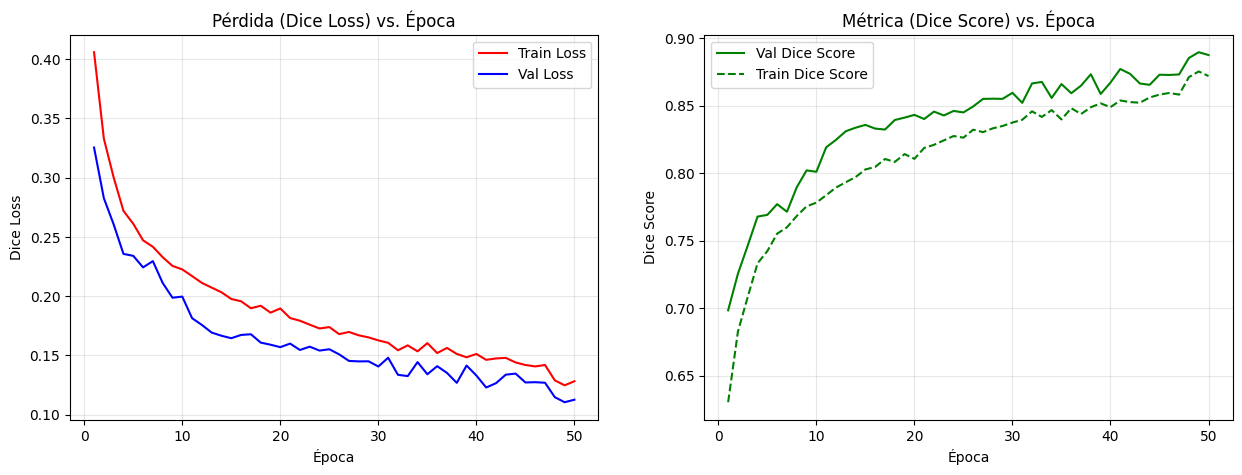

In [30]:
import matplotlib.pyplot as plt

# Asume que 'history' es el diccionario guardado con los resultados
# Ejemplo de estructura: history = {'train_loss': [...], 'val_loss': [...], 'val_dice': [...]}

def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    epochs = range(1, len(history['train_loss']) + 1)
    
    # --- Plot de Pérdida (Loss) ---
    ax1.plot(epochs, history['train_loss'], 'r', label='Train Loss')
    ax1.plot(epochs, history['val_loss'], 'b', label='Val Loss')
    ax1.set_title('Pérdida (Dice Loss) vs. Época')
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Dice Loss')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # --- Plot de Métricas (Dice Score) ---
    ax2.plot(epochs, history['val_dice'], 'g', label='Val Dice Score')
    ax2.plot(epochs, history['train_dice'], 'g--', label='Train Dice Score')
    ax2.set_title('Métrica (Dice Score) vs. Época')
    ax2.set_xlabel('Época')
    ax2.set_ylabel('Dice Score')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.show()

# Ejecutar el plot (una vez que tu diccionario history esté disponible)
plot_history(history)

# Ver Predicciones

In [14]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import matplotlib.pyplot as plt

# --- CONSTANTES ACTUALES ---
IMG_HEIGHT = 256
IMG_WIDTH = 256
MEAN = [0.515, 0.484, 0.460] 
STD = [0.314, 0.303, 0.303]
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CHECKPOINT_PATH = "unet_best_checkpoint.pth.tar"
# ---------------------------

def get_test_transforms(mean, std):
    """Transformaciones necesarias para la inferencia (Redimensionar y Normalizar)."""
    return A.Compose([
        A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH, always_apply=True),
        A.Normalize(mean=mean, std=std, max_pixel_value=255.0),
        ToTensorV2(),
    ])

def predict_and_upsample(model, image_np, original_shape, device):
    """Predice en 256x256 y re-escala a la forma original (800x800)."""
    model.eval()
    
    # 1. Aplicar Transformación (Redimensionamiento a 256x256)
    test_transforms = get_test_transforms(MEAN, STD)
    transformed = test_transforms(image=image_np)
    image_tensor = transformed['image'].unsqueeze(0).to(device) # (C, H, W) -> (1, C, H, W)

    with torch.no_grad():
        # Obtener logits de la U-Net (256x256)
        output_logits = model(image_tensor) 

    # 2. Re-escalar la predicción a la forma original (800x800)
    upsampled_output = F.interpolate(
        output_logits, 
        size=original_shape, 
        mode='bilinear', 
        align_corners=False
    )

    # 3. Convertir a Máscara Binaria
    probabilities = torch.sigmoid(upsampled_output).squeeze().cpu().numpy()
    final_mask = (probabilities > 0.5).astype(np.uint8) 
    
    return final_mask

def load_best_model(path, model, device):
    """Carga el mejor estado del modelo desde el checkpoint."""
    print(f"Cargando checkpoint desde {path}...")
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['state_dict'])
    print(f"Modelo cargado. Mejor Dice Score de validación: {checkpoint['best_dice']:.4f}")
    model.eval()
    return model

In [15]:
def visualize_comparison(model, image_path, mask_path, device):
    
    # 1. Cargar datos originales (800x800)
    original_img_np = np.array(Image.open(image_path).convert("RGB"))
    # La máscara GT también debe ser cargada y convertida a binario (0 o 1)
    ground_truth_mask_np = np.array(Image.open(mask_path).convert("L")) / 255
    original_shape = original_img_np.shape[:2]

    # 2. Generar Predicción Re-Escalada
    final_mask_800x800 = predict_and_upsample(model, original_img_np, original_shape, device)
    
    # 3. Calcular la métrica Dice Score específica para este ejemplo
    intersection = np.sum(final_mask_800x800 * ground_truth_mask_np)
    union = np.sum(final_mask_800x800) + np.sum(ground_truth_mask_np)
    dice_score = (2.0 * intersection) / union if union > 0 else 0.0

    # 4. Crear Overlay para visualización (Máscara Predicha sobre Imagen Original)
    overlay_img = original_img_np.copy()
    purple_color = (200, 50, 200) # Color para la predicción
    # Aplicar la máscara predicha con un 50% de transparencia
    overlay_img[final_mask_800x800 == 1] = (
        overlay_img[final_mask_800x800 == 1] * 0.5 + np.array(purple_color) * 0.5
    ).astype(np.uint8)

    # 5. Plotear
    fig, axes = plt.subplots(1, 3, figsize=(15, 6))
    plt.suptitle(f'Visualización de Segmentación | Dice Score: {dice_score:.4f}', fontsize=16)
    
    axes[0].imshow(original_img_np)
    axes[0].set_title('Imagen Original')
    
    axes[1].imshow(ground_truth_mask_np, cmap='gray')
    axes[1].set_title('Máscara Ground Truth')
    
    axes[2].imshow(overlay_img)
    axes[2].set_title('Predicción Overlay (Máscara Predicha)')
    
    for ax in axes:
        ax.axis('off')
    plt.show()

In [16]:
# Asegúrate de que tu clase UNet esté importada y definida
best_model = load_best_model(CHECKPOINT_PATH, model, DEVICE)

Cargando checkpoint desde unet_best_checkpoint.pth.tar...
Modelo cargado. Mejor Dice Score de validación: 0.8895


In [33]:
# Reemplaza estas rutas de ejemplo con las rutas reales de tus archivos
example_img_path = 'train/images/4.png' 
example_mask_path = 'train/masks/4.png'

C:\Users\kidni\AppData\Local\Temp\ipykernel_25848\2251217385.py:22: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH, always_apply=True),


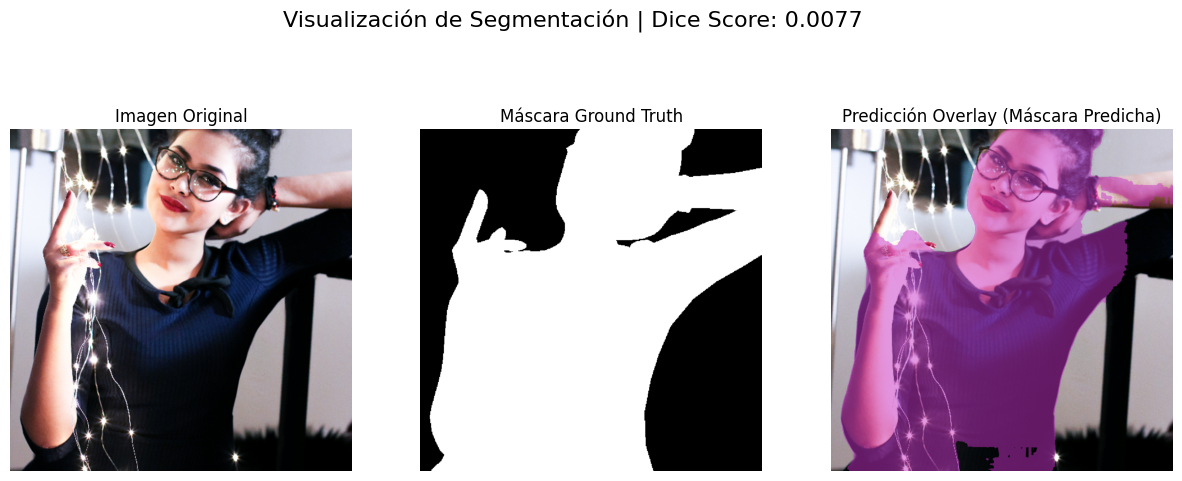

In [34]:
visualize_comparison(best_model, example_img_path, example_mask_path, DEVICE)

# Predecir en Test

In [26]:
import torch
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import os
# (También asegúrate de que las funciones predict_and_upsample y load_best_model estén definidas)

# --- CONSTANTES ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CHECKPOINT_PATH = "unet_best_checkpoint.pth.tar"
TEST_IMAGES_DIR = 'test/images' # **AJUSTAR ESTA RUTA**
# ------------------

# 1. Cargar el mejor modelo
model = UNet(n_channels=3, n_classes=1).to(DEVICE) 
best_model = load_best_model(CHECKPOINT_PATH, model, DEVICE)

Cargando checkpoint desde unet_best_checkpoint.pth.tar...
Modelo cargado. Mejor Dice Score de validación: 0.8895


In [27]:
def rle_encode(img):
    """
    Convierte una máscara binaria (1s y 0s) en una cadena de Run-Length Encoding.
    img: numpy array de 1s y 0s, 1 - objeto, 0 - fondo
    Returns: cadena de RLE
    """
    # Flatten: Asegurarse de que el orden sea columna por columna (F-order)
    pixels = img.T.flatten() 
    
    # Agrega 0s al inicio y final para asegurar que se capturen los bordes
    pixels = np.concatenate([[0], pixels, [0]])
    
    # Encuentra los índices donde hay un cambio (de 0 a 1 o de 1 a 0)
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    
    # El RLE es la lista de (Inicio, Longitud). 
    # Los inicios están en índices pares (0, 2, 4...)
    # Las longitudes están en índices impares (1, 3, 5...)
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [29]:
def generate_submission(model, test_dir, device):
    
    # Lista para almacenar los resultados (ImageId, EncodedPixels)
    results = []
    
    # Obtener la lista de nombres de archivo (asumiendo formato .png)
    image_files = sorted([f for f in os.listdir(test_dir) if f.endswith('.png')])
    
    print(f"Iniciando predicción para {len(image_files)} imágenes de prueba...")

    for i, filename in enumerate(image_files):
        
        # 1. Cargar Imagen Original
        filepath = os.path.join(test_dir, filename)
        original_img_np = np.array(Image.open(filepath).convert("RGB"))
        original_shape = original_img_np.shape[:2] # (Alto, Ancho)
        
        # 2. Predecir y Re-escalar a 800x800
        # **Usamos la función que integra Resize(256) -> UNet -> Upsample(800)**
        final_mask_800x800 = predict_and_upsample(model, original_img_np, original_shape, device)
        
        # 3. Codificar RLE
        rle_encoded = rle_encode(final_mask_800x800)
        
        # 4. Guardar Resultado
        results.append({'id': filename, 'encoded_pixels': rle_encoded})
        
        # Progreso
        if (i + 1) % 50 == 0:
            print(f"Predicciones procesadas: {i + 1}/{len(image_files)}")

    # 5. Crear DataFrame de Envío
    submission_df = pd.DataFrame(results)
    return submission_df

# --- EJECUCIÓN FINAL ---
# Generar el DataFrame
submission_df = generate_submission(best_model, TEST_IMAGES_DIR, DEVICE)

# Guardar el archivo CSV
SUBMISSION_FILE = "submission_baseline_256x256.csv"
submission_df.to_csv(SUBMISSION_FILE, index=False)

print(f"\n✅ Archivo de envío generado: {SUBMISSION_FILE}")
print("Puedes subir este archivo a Kaggle para obtener el Dice Score final.")

Iniciando predicción para 534 imágenes de prueba...


C:\Users\kidni\AppData\Local\Temp\ipykernel_25848\2251217385.py:22: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH, always_apply=True),


Predicciones procesadas: 50/534
Predicciones procesadas: 100/534
Predicciones procesadas: 150/534
Predicciones procesadas: 200/534
Predicciones procesadas: 250/534
Predicciones procesadas: 300/534
Predicciones procesadas: 350/534
Predicciones procesadas: 400/534
Predicciones procesadas: 450/534
Predicciones procesadas: 500/534

✅ Archivo de envío generado: submission_baseline_256x256.csv
Puedes subir este archivo a Kaggle para obtener el Dice Score final.
